In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

stl_path = "../processed_data/stl_energy_production_with_engineered_features.csv"
hp_path = "../processed_data/hp_energy_production_with_engineered_features.csv"


stl_df = pd.read_csv(stl_path)
hp_df = pd.read_csv(hp_path)

original_features = ["Water_Flow_m3_s", "avgtempC", "totalprecipMM", "humidity", "pressureMB"]
engineered_features = original_features + [
    "WaterFlow_Diff_1d", "WaterFlow_Diff_7d",
    "WaterFlow_3day_avg", "WaterFlow_7day_avg",
    "Temp_Deviation", "WaterFlow_Humidity",
    "month_sin", "month_cos",
    "Normalized_Efficiency", "Prev_Day_Efficiency", "Prev_Week_Efficiency"
]
target = "Efficiency"


def train_and_evaluate_model(df, feature_set, dataset_name):
    X = df[feature_set]
    y = df[target]


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
    y_test_actual = y_test.to_numpy()

    models = {
        "Linear Regression": LinearRegression(),
        "Polynomial Regression (Degree 2)": PolynomialFeatures(degree=2),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(n_estimators=100,max_depth=10, random_state=42)
    }

    results = []
    predictions = {}
    feature_importances = {}

    for model_name, model in models.items():
        if "Polynomial" in model_name:
            poly = PolynomialFeatures(degree=2)
            X_train_poly = poly.fit_transform(X_train)
            X_test_poly = poly.transform(X_test)
            model = LinearRegression()
            model.fit(X_train_poly, y_train_scaled)
            y_train_pred = model.predict(X_train_poly)
            y_test_pred = model.predict(X_test_poly)
            
            feature_importances[model_name] = np.abs(model.coef_) if hasattr(model, "coef_") else None
            feature_names = poly.get_feature_names_out(input_features=feature_set)
        else:
            model.fit(X_train, y_train_scaled)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            if hasattr(model, "feature_importances_"):
                feature_importances[model_name] = model.feature_importances_
            else:
                feature_importances[model_name] = None  

        # Transform predictions back to original scale
        y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
        y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()

        # Evaluate Model
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test_actual, y_test_pred)
        mae = mean_absolute_error(y_test_actual, y_test_pred)
        rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

        results.append([model_name, r2_train, r2_test, mae, rmse])
        predictions[model_name] = y_test_pred  

    results_df = pd.DataFrame(results, columns=["Model", "R² Train", "R² Test", "MAE", "RMSE"]) 
    return results_df, predictions, feature_importances, y_test_actual


def train_and_evaluate_advanced_models(df, feature_set, dataset_name):
    X = df[feature_set]
    y = df[target]


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
    y_test_actual = y_test.to_numpy()

    models = {
        "XGBoost": XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42, verbosity=0),
        "LightGBM": LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42, verbose=-1),
        "CatBoost": CatBoostRegressor(n_estimators=100, depth=5, learning_rate=0.05, random_state=42, verbose=0),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=42),
        "Support Vector Regression": SVR(),
        "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Ridge Regression": Ridge(alpha=1.0),
        "Multiple Linear Regression (MLR)": LinearRegression()
    }

    results = []
    predictions = {}
    feature_importances = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train_scaled)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        if hasattr(model, "feature_importances_"):
            feature_importances[model_name] = model.feature_importances_
        else:
            feature_importances[model_name] = None  

        # Transform predictions back to original scale
        y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
        y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()

        # Evaluate Model
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test_actual, y_test_pred)
        mae = mean_absolute_error(y_test_actual, y_test_pred)
        rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

        results.append([model_name, r2_train, r2_test, mae, rmse])
        predictions[model_name] = y_test_pred  

    results_df = pd.DataFrame(results, columns=["Model", "R² Train", "R² Test", "MAE", "RMSE"])
    return results_df, predictions, feature_importances, y_test_actual

stl_results_original, stl_predictions_original, stl_y_test_original, stl_importances_original = train_and_evaluate_model(stl_df, original_features, "STL Model - Original Features")
hp_results_original, hp_predictions_original, hp_y_test_original, hp_importances_original = train_and_evaluate_model(hp_df, original_features, "HP Model - Original Features")

stl_results_engineered, stl_predictions_engineered, stl_y_test_engineered, stl_importances_engineered = train_and_evaluate_model(stl_df, engineered_features, "STL Model - Engineered Features")
hp_results_engineered, hp_predictions_engineered, hp_y_test_engineered, hp_importances_engineered = train_and_evaluate_model(hp_df, engineered_features, "HP Model - Engineered Features")

stl_results_advanced_original, stl_predictions_advanced_original, stl_y_test_advanced_original, stl_importances_advanced_original = train_and_evaluate_advanced_models(stl_df, original_features, "STL Advanced - Original Features")
hp_results_advanced_original, hp_predictions_advanced_original, hp_y_test_advanced_original, hp_importances_advanced_original = train_and_evaluate_advanced_models(hp_df, original_features, "HP Advanced - Original Features")

stl_results_advanced_engineered, stl_predictions_advanced_engineered, stl_y_test_advanced_engineered, stl_importances_advanced_engineered = train_and_evaluate_advanced_models(stl_df, engineered_features, "STL Advanced - Engineered Features")
hp_results_advanced_engineered, hp_predictions_advanced_engineered, hp_y_test_advanced_engineered, hp_importances_advanced_engineered = train_and_evaluate_advanced_models(hp_df, engineered_features, "HP Advanced - Engineered Features")


print("\n STL Model - Original Features")
print(stl_results_original.to_string(index=False))

print("\n HP Model - Original Features")
print(hp_results_original.to_string(index=False))

print("\n STL Model - Engineered Features")
print(stl_results_engineered.to_string(index=False))

print("\n HP Model - Engineered Features")
print(hp_results_engineered.to_string(index=False))

print("\n STL Advanced - Original Features")
print(stl_results_advanced_original.to_string(index=False))

print("\n HP Advanced - Original Features")
print(hp_results_advanced_original.to_string(index=False))

print("\n STL Advanced - Engineered Features")
print(stl_results_advanced_engineered.to_string(index=False))

print("\n HP Advanced - Engineered Features")
print(hp_results_advanced_engineered.to_string(index=False))



 STL Model - Original Features
                           Model  R² Train   R² Test      MAE     RMSE
               Linear Regression  0.004784 -0.000149 0.195327 6.151465
Polynomial Regression (Degree 2)  0.008164 -0.000022 0.196357 6.151076
                   Decision Tree  0.679205  0.117264 0.187645 5.779120
                   Random Forest  0.627365  0.085253 0.179738 5.882973

 HP Model - Original Features
                           Model  R² Train   R² Test      MAE     RMSE
               Linear Regression  0.003212 -0.000053 0.228711 5.076118
Polynomial Regression (Degree 2)  0.016187  0.000029 0.238992 5.075910
                   Decision Tree  0.505896  0.105655 0.241540 4.800347
                   Random Forest  0.414033  0.068934 0.223413 4.897906

 STL Model - Engineered Features
                           Model  R² Train  R² Test          MAE         RMSE
               Linear Regression  1.000000 1.000000 1.756240e-16 1.282738e-15
Polynomial Regression (Degree 2)  0.9

In [12]:
import os

def save_plot(fig, filename, folder="ML"):
    os.makedirs(folder, exist_ok=True) 
    filepath = os.path.join(folder, f"{filename}.png")
    fig.savefig(filepath, bbox_inches="tight")
    plt.close(fig)

In [50]:
def save_predictions_plot(y_test_actual, predictions_dict, title, filename):
    fig = plt.figure(figsize=(12, 6))

    if isinstance(y_test_actual, dict):  
        y_test_actual = np.array(list(y_test_actual.values())[0])

    plt.plot(y_test_actual, label="Actual", linestyle="dashed", color="black", alpha=0.7)

    for model_name, y_pred in predictions_dict.items():
        y_pred = np.array(y_pred)  
        plt.plot(y_pred, label=f"{model_name} Prediction", alpha=0.8)

    plt.title(title)
    plt.legend()
    plt.xlabel("Sample Index")
    plt.ylabel("Efficiency")

    save_plot(fig, filename, folder="ML")

In [51]:
save_predictions_plot(stl_y_test_original, stl_predictions_original, 
                      "STL Model Predictions (Original Features)", 
                      "stl_model_predictions_original")

save_predictions_plot(hp_y_test_original, hp_predictions_original, 
                      "HP Model Predictions (Original Features)", 
                      "hp_model_predictions_original")

save_predictions_plot(stl_y_test_engineered, stl_predictions_engineered, 
                      "STL Model Predictions (Engineered Features)", 
                      "stl_model_predictions_engineered")

save_predictions_plot(hp_y_test_engineered, hp_predictions_engineered, 
                      "HP Model Predictions (Engineered Features)", 
                      "hp_model_predictions_engineered")

save_predictions_plot(stl_y_test_advanced_original, stl_predictions_advanced_original, 
                      "STL Advanced Model Predictions (Original Features)", 
                      "stl_advanced_model_predictions_original")

save_predictions_plot(hp_y_test_advanced_original, hp_predictions_advanced_original, 
                      "HP Advanced Model Predictions (Original Features)", 
                      "hp_advanced_model_predictions_original")

save_predictions_plot(stl_y_test_advanced_engineered, stl_predictions_advanced_engineered, 
                      "STL Advanced Model Predictions (Engineered Features)", 
                      "stl_advanced_model_predictions_engineered")

save_predictions_plot(hp_y_test_advanced_engineered, hp_predictions_advanced_engineered, 
                      "HP Advanced Model Predictions (Engineered Features)", 
                      "hp_advanced_model_predictions_engineered")


In [18]:
def save_model_metrics_plot(results_df, title, filename):
    metrics = ["R² Train", "R² Test", "MAE", "RMSE"]
    if "Model" not in results_df.columns:
        results_df.reset_index(inplace=True)  
    results_df.set_index("Model", inplace=True)
    
    fig = plt.figure(figsize=(14, 6))
    results_df[metrics].plot(kind="bar", colormap="viridis", alpha=0.8)
    plt.title(title)
    plt.xlabel("Model")
    plt.ylabel("Metric Values")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Metrics")
    
    save_plot(fig, filename, folder="ML")  
    plt.close()

In [19]:
save_model_metrics_plot(stl_results_original, "STL Model Metrics (Original Features)", "stl_metrics_original")
save_model_metrics_plot(hp_results_original, "HP Model Metrics (Original Features)", "hp_metrics_original")
save_model_metrics_plot(stl_results_engineered, "STL Model Metrics (Engineered Features)", "stl_metrics_engineered")
save_model_metrics_plot(hp_results_engineered, "HP Model Metrics (Engineered Features)", "hp_metrics_engineered")

save_model_metrics_plot(stl_results_advanced_original, "STL Advanced Model Metrics (Original Features)", "stl_advanced_metrics_original")
save_model_metrics_plot(hp_results_advanced_original, "HP Advanced Model Metrics (Original Features)", "hp_advanced_metrics_original")
save_model_metrics_plot(stl_results_advanced_engineered, "STL Advanced Model Metrics (Engineered Features)", "stl_advanced_metrics_engineered")
save_model_metrics_plot(hp_results_advanced_engineered, "HP Advanced Model Metrics (Engineered Features)", "hp_advanced_metrics_engineered")


In [30]:
def save_performance_comparison(results_dict, title, filename):
    plt.figure(figsize=(14, 6))

    for dataset, df in results_dict.items():
        if "Model" not in df.columns:
            df.reset_index(inplace=True) 
        plt.plot(df["Model"], df["R² Test"], marker="o", label=f"{dataset} R² Test")

    plt.title(title)
    plt.xlabel("Model")
    plt.ylabel("R² Test Score")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.grid()
    save_plot(plt.gcf(), filename, folder="ML")
    plt.close()  


model_results = {
    "STL Original": stl_results_original,
    "HP Original": hp_results_original,
    "STL Engineered": stl_results_engineered,
    "HP Engineered": hp_results_engineered,
    "STL Advanced Original": stl_results_advanced_original,
    "HP Advanced Original": hp_results_advanced_original,
    "STL Advanced Engineered": stl_results_advanced_engineered,
    "HP Advanced Engineered": hp_results_advanced_engineered,
}

save_performance_comparison(model_results, "Model Performance Comparison (All Models)", "model_performance_comparison")



📊 Plotting Average Feature Importance


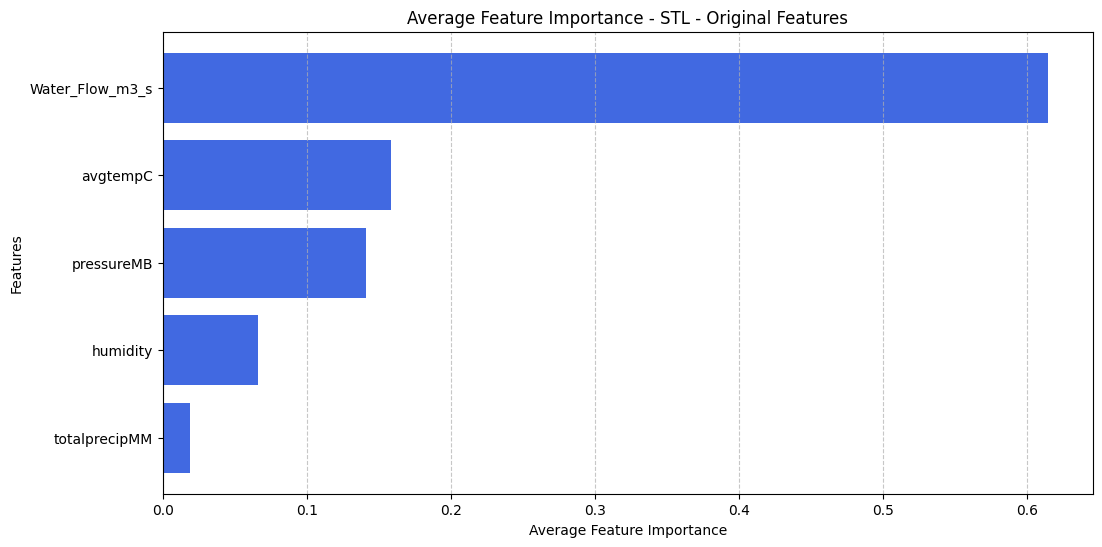

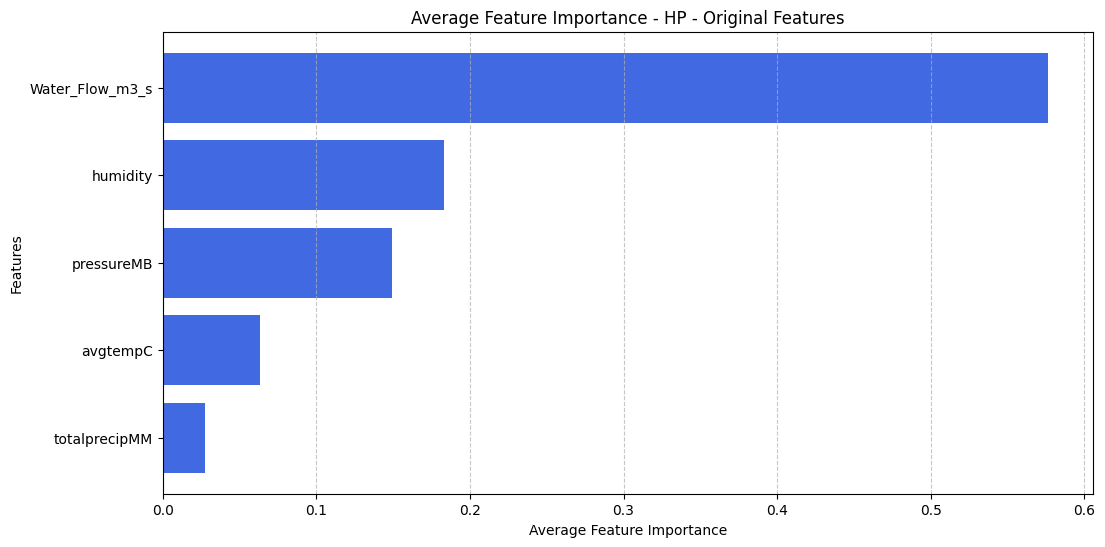

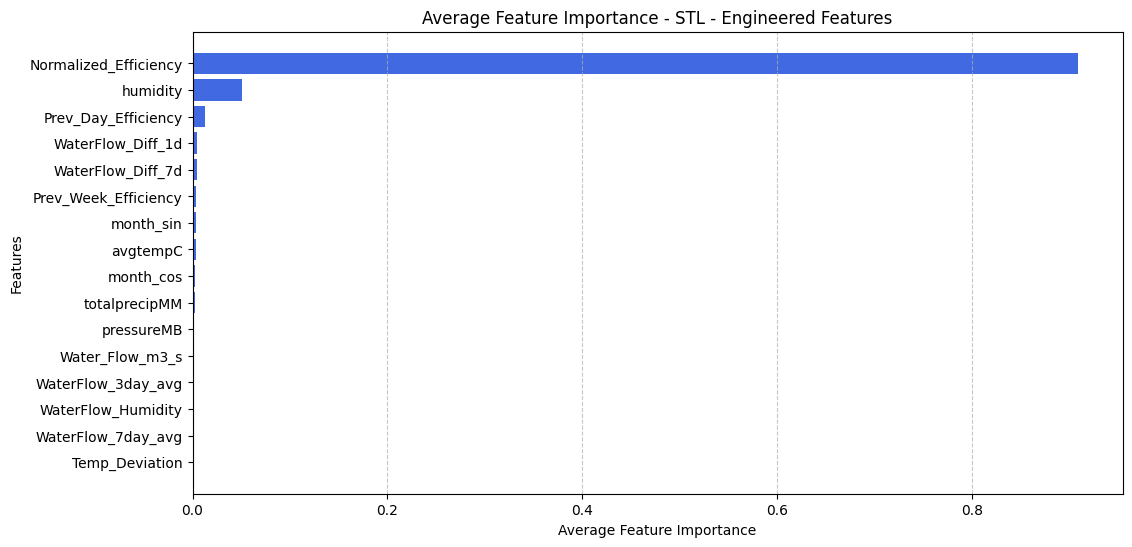

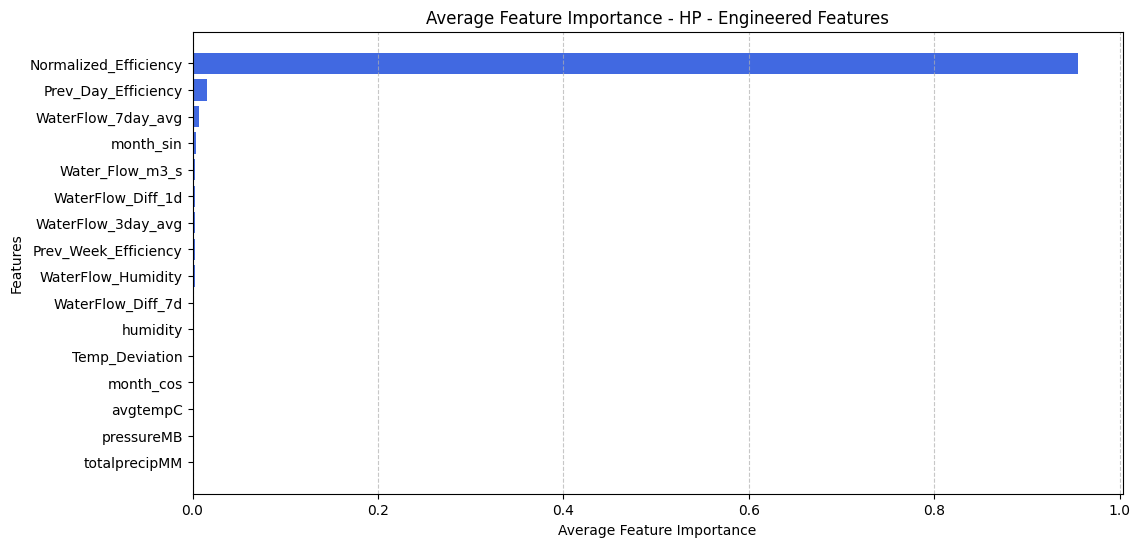

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_average_feature_importance(importances_dict, feature_names, dataset_name):
    valid_importances = [imp for imp in importances_dict.values() if imp is not None and len(imp) == len(feature_names)]

    if not valid_importances:
        print(f"No valid feature importances found for {dataset_name}")
        return
    
    avg_importance = np.mean(valid_importances, axis=0)  # Average feature importance

    sorted_idx = np.argsort(avg_importance)[::-1]
    sorted_features = np.array(feature_names)[sorted_idx]
    sorted_importance = avg_importance[sorted_idx]

    plt.figure(figsize=(12, 6))
    plt.barh(sorted_features, sorted_importance, color="royalblue")
    plt.xlabel("Average Feature Importance")
    plt.ylabel("Features")
    plt.title(f"Average Feature Importance - {dataset_name}")
    plt.gca().invert_yaxis()  # Highest importance on top
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

print("\n📊 Plotting Average Feature Importance")

plot_average_feature_importance(stl_importances_original, original_features, "STL - Original Features")
plot_average_feature_importance(hp_importances_original, original_features, "HP - Original Features")
plot_average_feature_importance(stl_importances_engineered, engineered_features, "STL - Engineered Features")
plot_average_feature_importance(hp_importances_engineered, engineered_features, "HP - Engineered Features")


In [35]:
# Function to save ML model comparison plots
def save_ml_comparison_plots(stl_results, hp_results, filename_r2, filename_mae):
    all_models = stl_results["Model"].tolist()

    ml_comparison_df = pd.DataFrame({
        "Model": all_models,
        "STL R²": [stl_results.loc[stl_results["Model"] == m, "R² Test"].values[0] for m in all_models],
        "HP R²": [hp_results.loc[hp_results["Model"] == m, "R² Test"].values[0] for m in all_models],
        "STL MAE": [stl_results.loc[stl_results["Model"] == m, "MAE"].values[0] for m in all_models],
        "HP MAE": [hp_results.loc[hp_results["Model"] == m, "MAE"].values[0] for m in all_models]
    })

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # R² Score Comparison
    ml_comparison_df.plot(x="Model", y=["STL R²", "HP R²"], kind="bar", ax=axes[0], color=["blue", "orange"])
    axes[0].set_title("R² Score Comparison (STL vs HP)")
    axes[0].set_ylabel("R² Score")
    axes[0].set_xticklabels(ml_comparison_df["Model"], rotation=45, ha="right")

    # MAE Score Comparison
    ml_comparison_df.plot(x="Model", y=["STL MAE", "HP MAE"], kind="bar", ax=axes[1], color=["green", "red"])
    axes[1].set_title("MAE Score Comparison (STL vs HP)")
    axes[1].set_ylabel("Mean Absolute Error (MAE)")
    axes[1].set_xticklabels(ml_comparison_df["Model"], rotation=45, ha="right")

    plt.tight_layout()
    plt.savefig(f"ML/{filename_r2}.png", bbox_inches="tight")
    plt.savefig(f"ML/{filename_mae}.png", bbox_inches="tight")

    plt.close()

save_ml_comparison_plots(stl_results_advanced_engineered, hp_results_advanced_engineered, 
                         "ml_comparison_r2", "ml_comparison_mae")


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define model names
all_models = stl_results_advanced_engineered["Model"].tolist()

# Extract metrics for STL and HP models
metrics = ["R² Test", "MAE", "RMSE"]

ml_comparison_df = pd.DataFrame({
    "Model": all_models,
    "STL R²": [stl_results_advanced_engineered.loc[stl_results_advanced_engineered["Model"] == m, "R² Test"].values[0] for m in all_models],
    "HP R²": [hp_results_advanced_engineered.loc[hp_results_advanced_engineered["Model"] == m, "R² Test"].values[0] for m in all_models],
    "STL MAE": [stl_results_advanced_engineered.loc[stl_results_advanced_engineered["Model"] == m, "MAE"].values[0] for m in all_models],
    "HP MAE": [hp_results_advanced_engineered.loc[hp_results_advanced_engineered["Model"] == m, "MAE"].values[0] for m in all_models],
    "STL RMSE": [stl_results_advanced_engineered.loc[stl_results_advanced_engineered["Model"] == m, "RMSE"].values[0] for m in all_models],
    "HP RMSE": [hp_results_advanced_engineered.loc[hp_results_advanced_engineered["Model"] == m, "RMSE"].values[0] for m in all_models]
})

# Plot grouped bar chart for all three metrics
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.2  # Width of each bar
x_labels = ml_comparison_df["Model"]
x = np.arange(len(x_labels))

# STL bars
ax.bar(x - bar_width, ml_comparison_df["STL R²"], bar_width, label="STL R²", color="blue")
ax.bar(x, ml_comparison_df["STL MAE"], bar_width, label="STL MAE", color="green")
ax.bar(x + bar_width, ml_comparison_df["STL RMSE"], bar_width, label="STL RMSE", color="purple")

# HP bars
ax.bar(x + 2*bar_width, ml_comparison_df["HP R²"], bar_width, label="HP R²", color="orange")
ax.bar(x + 3*bar_width, ml_comparison_df["HP MAE"], bar_width, label="HP MAE", color="red")
ax.bar(x + 4*bar_width, ml_comparison_df["HP RMSE"], bar_width, label="HP RMSE", color="brown")

ax.set_xticks(x + bar_width)
ax.set_xticklabels(x_labels, rotation=45, ha="right")
ax.set_ylabel("Metric Value")
ax.set_xlabel("Models")
ax.set_title("ML Model Performance Comparison (STL vs HP)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Save the plot
plt.savefig("ML/ml_model_performance_comparison.png", bbox_inches="tight")
plt.close()


In [38]:
def ensure_numpy_array(y_data):
    if isinstance(y_data, dict):  
        return np.array(list(y_data.values())[0])
    return np.array(y_data)

def save_predictions_plot(y_actual, predictions_dict, dataset_name, filename):
    plt.figure(figsize=(12, 6))

    y_actual = ensure_numpy_array(y_actual)

    plt.plot(y_actual, label="Actual", color="black", linestyle="dotted")

    for model_name, y_pred in predictions_dict.items():
        plt.plot(np.array(y_pred), label=model_name, alpha=0.7)  

    plt.title(f"Model Predictions vs Actual Data ({dataset_name})")
    plt.xlabel("Time")
    plt.ylabel("Efficiency")
    plt.legend()

    plt.savefig(f"ML/{filename}.png", bbox_inches="tight")
    plt.close()

stl_y_test_advanced_engineered = ensure_numpy_array(stl_y_test_advanced_engineered)
hp_y_test_advanced_engineered = ensure_numpy_array(hp_y_test_advanced_engineered)

stl_selected_predictions = {m: np.array(y) for m, y in stl_predictions_advanced_engineered.items()}
hp_selected_predictions = {m: np.array(y) for m, y in hp_predictions_advanced_engineered.items()}

save_predictions_plot(stl_y_test_advanced_engineered, stl_selected_predictions, "STL Engineered", "stl_predictions_engineered")
save_predictions_plot(hp_y_test_advanced_engineered, hp_selected_predictions, "HP Engineered", "hp_predictions_engineered")
